# 쇼핑몰 리뷰 평점 예측 모델
- 데이터 출처: [네이버 쇼핑](https://shopping.naver.com/home)
- [쇼핑몰 리뷰 평점 예측 대회](https://dacon.io/competitions/official/235938/overview/description)

In [5]:
# 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, re
import seaborn as sns

from wordcloud import wordcloud
%matplotlib inline

In [9]:
# 폰트 설치
import matplotlib.font_manager as fm

In [10]:
[f for f in fm.findSystemFonts() if f.lower().find('nanum') > -1]

['C:\\Users\\Tanks\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumGothicExtraBold.ttf',
 'C:\\Users\\Tanks\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumGothicBold.ttf',
 'C:\\Users\\Tanks\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquare.ttf',
 'C:\\Users\\Tanks\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquareL.ttf',
 'C:\\Users\\Tanks\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumGothic.ttf',
 'C:\\Users\\Tanks\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquareB.ttf',
 'C:\\Users\\Tanks\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquareR.ttf',
 'C:\\Users\\Tanks\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquare_acR.ttf',
 'C:\\Users\\Tanks\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquare_0.ttf',
 'C:\\Users\\Tanks\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumPen.otf',
 'C:\\Users\\Tanks\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquareEB.ttf',
 'C:\\Users\\Tanks\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumGothicLight.ttf',
 '

In [11]:
font_path = 'C:\\Users\\Tanks\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumGothic.ttf'
font = fm.FontProperties(fname=font_path, size=9)

## 데이터 분석

### 데이터 읽어오기

In [6]:
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/test.csv')
sample = pd.read_csv('./dataset/sample_submission.csv')

In [7]:
train.head()

,id,reviews,target
0,0,조아요 처음구입 싸게햇어요,2
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2
4,4,튼튼하고 손목을 잘 받쳐주네요~,5


In [8]:
test.head()

,id,reviews
0,0,채소가 약간 시들어 있어요
1,1,발톱 두껍고 단단한 분들 써도 소용없어요 이 테이프 물렁거리고 힘이없어서 들어 올리...
2,2,부들부들 좋네요 입어보고 시원하면 또 살게요
3,3,이런 1. 8 골드 주라니깐 파란개 오네 회사전화걸어도 받지도 않고 머하자는거임?
4,4,검수도 없이 보내구 불량 배송비 5000원 청구하네요 완전별로 별하나도 아까워요


### 데이터 확인
#### train 데이터
- id: 샘플 id
- reviews: 쇼핑몰 리뷰 텍스트
- target: 평점

#### test 데이터
- id: 샘플 id
- reviews: 쇼핑몰 리뷰 텍스트

In [15]:
# 데이터 개수
print(train.shape, test.shape)

(25000, 3) (25000, 2)


### 글자 단위 텍스트 길이 분포 확인

In [16]:
train_length = train['reviews'].astype(str).apply(len)

Text(0, 0.5, 'Number of reviews')

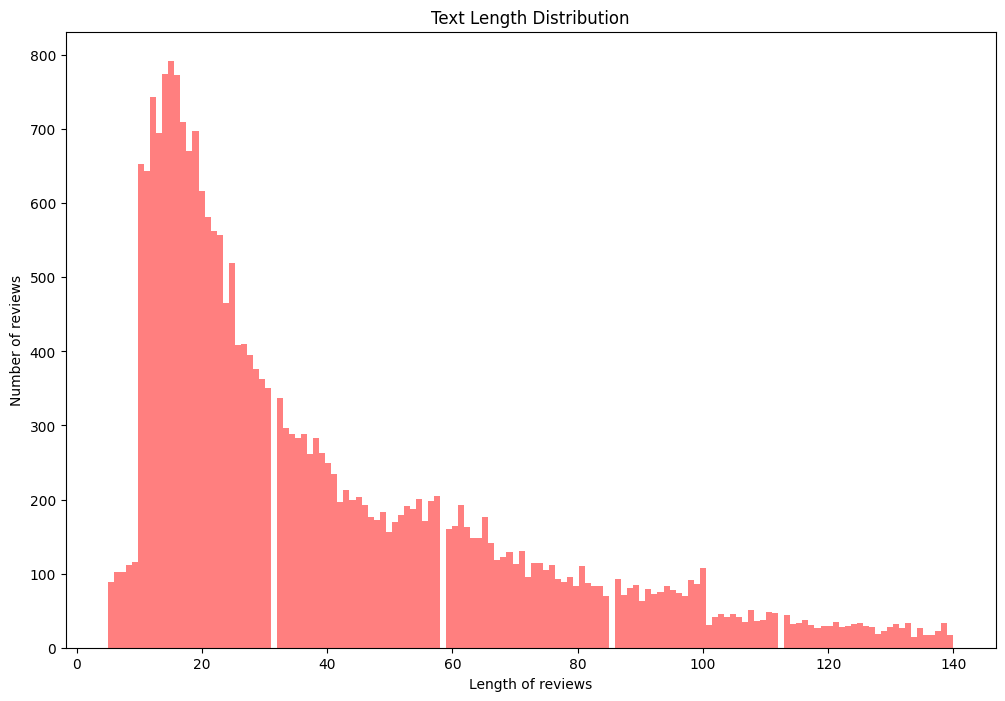

In [25]:
plt.figure(figsize=(12, 8))
plt.hist(train_length, bins=140, alpha=0.5, color='r', label='word')
plt.title('Text Length Distribution')
plt.xlabel('Length of reviews')
plt.ylabel('Number of reviews')

In [28]:
train_length.describe()

count    25000.00000
mean        39.98808
std         29.42369
min          5.00000
25%         17.00000
50%         29.00000
75%         56.00000
max        140.00000
Name: reviews, dtype: float64

### 단어 단위 텍스트 길이 분포

In [29]:
train_word_counts = train['reviews'].astype(str).apply(lambda x: len(x.split(' ')))

Text(0, 0.5, 'Number of counts')

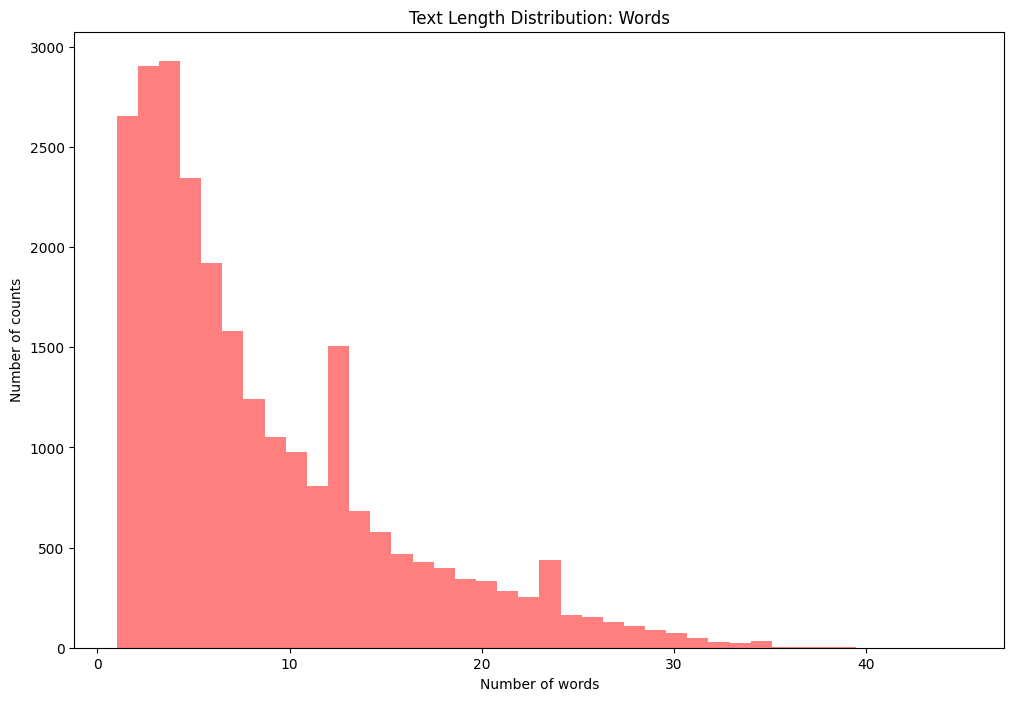

In [30]:
plt.figure(figsize=(12,8))
plt.hist(train_word_counts, bins=40, alpha=0.5, color='r', label='train')
plt.title('Text Length Distribution: Words')
plt.xlabel('Number of words')
plt.ylabel('Number of counts')

### 데이터 라벨 분포

<AxesSubplot:xlabel='target', ylabel='count'>

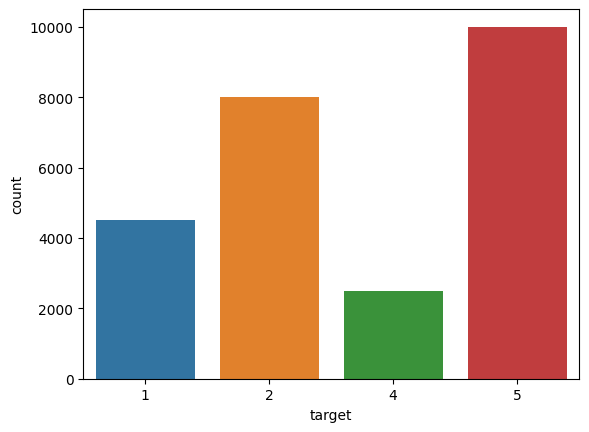

In [31]:
sns.countplot(x='target', data=train)

In [32]:
train['target'].value_counts()

5    10000
2     8000
1     4500
4     2500
Name: target, dtype: int64

## 워드클라우드

In [33]:
train_reviews = [review for review in train['reviews'] if type(review) is str]

In [35]:
train_reviews[:10]

['조아요 처음구입 싸게햇어요',
 '생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 아깝네요',
 '디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져있네요 ㅠ 귀찮아서 그냥쓰려구요 배송기사님은 친절하셨어요',
 '기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘플 써보고 마음에 들어 구매해 사용중 같은 제품을 팔지 않아 할수 없이 플러스를 구매했는데요, 감고나도 머리가 개운하지 않고 간지럽네요. 저랑은 잘 안맞는듯해요.',
 '튼튼하고 손목을 잘 받쳐주네요~',
 '배송은 먼저 구입하신 분들께서 오래걸린다고 하여 참고 기달렸습니다 생각보다 일찍도착해서 좋았구요,하루전날 배송 아저씨가 전화와서 내일1~3시사이에 온다고 하더니 7시에왔어요화나',
 '타이밍이 좋았는지 배송도 빠르고 맛있었어요! 크기가 두가지가 있길래 큰걸 사봤는데 기존에 사먹어봤던거랑 크기 차이는 없네요 그래도 신선하고 맛있어요!',
 '상품 퀄리티가 좋지 않아요',
 '재구매 평소 사용하던 제품이에요. 한번에 쟁여두려 여러개 삽니다 .',
 '두께 때문에 별로네요..']

In [36]:
wordcloud = wordcloud.WordCloud(font_path=font_path).generate(' '.join(train_reviews))

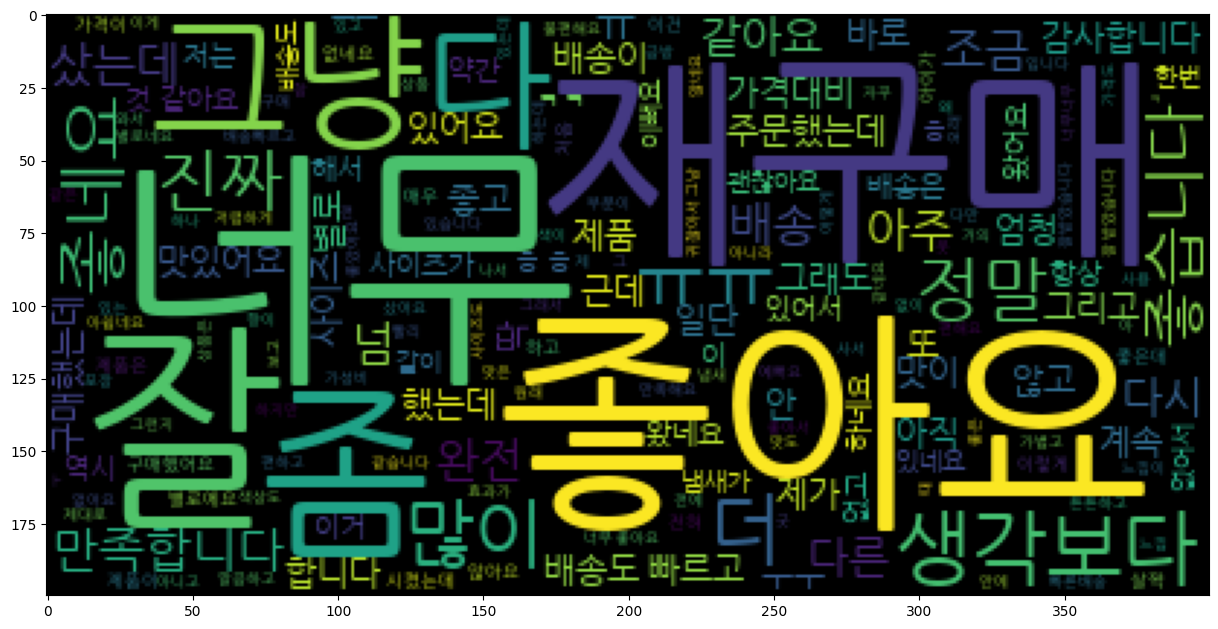

In [37]:
plt.figure(figsize=(15,12))
plt.imshow(wordcloud)

## 데이터 전처리

In [38]:
# 전처리를 위한 라이브러리
import json
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tqdm import tqdm

In [65]:
train['reviews'] = train['reviews'].astype(str).apply(lambda x : re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]', '', x))

### 토큰화(Tokenizing), 형태소 분석

In [66]:
okt = Okt()

In [67]:
# 불용어 제거
stop_words = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [68]:
def preprocessing(text, okt, remove_stopwords=False, stop_words=[]):
    word_review = okt.morphs(text, stem=True)
    
    if remove_stopwords and len(stop_words) > 0:
        word_review = [word for word in word_review if word not in stop_words]
        
    return word_review

In [69]:
clean_train_reviews = []
for i in tqdm(range(len(train))):
    clean_train_reviews.append(preprocessing(train['reviews'][i], okt, True, stop_words))

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [00:42<00:00, 586.55it/s]


In [70]:
train_reviews[0]

'조아요 처음구입 싸게햇어요'

In [71]:
clean_train_reviews[0]

['좋다', '처음', '구입', '싸다', '햇', '어', '요']

### 단어 사전 생성 및 인덱싱

In [72]:
tokenizer = Tokenizer()

In [73]:
tokenizer.fit_on_texts(clean_train_reviews)

In [74]:
train_sequences = tokenizer.texts_to_sequences(clean_train_reviews)

In [75]:
len(train_sequences)

25000

In [76]:
train_sequences[0]

[1, 118, 94, 66, 342, 174, 4]

In [77]:
train_targets = np.array(train['target'])

In [78]:
train_targets

array([2, 1, 2, ..., 4, 2, 5], dtype=int64)

### 패딩 작업

In [79]:
MAX_SEQUENCE_LENGTH = 15

In [80]:
train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [82]:
for i in range(5):
    print(len(train_inputs[i]))

15
15
15
15
15


In [62]:
train_inputs[:5]

array([[   2,  128,  103,   72,  358,  191,    6,    0,    0,    0,    0,
           0,    0,    0,    0],
       [  11,  209,  690,  369,  300,  568,   11,  209,   48, 8719, 2664,
         133, 1220,    3,  262],
       [ 556,   33,   68,  275,  875, 1123,  114,   59,  165,   29,  904,
           4,  461,  386,  337],
       [  40,  349,  342, 2528,   15, 1691,    1,   93, 1392,   10,   11,
          62,  173,    6,    1],
       [ 140, 1884,   27,   10, 1629,   14,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])

In [63]:
len(tokenizer.index_word)

16663

## 모델링

In [64]:
train.shape, test.shape

((25000, 3), (25000, 2))

In [83]:
# 학습 및 평가 데이터 분리
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(train_inputs, train_targets, test_size=0.1)

In [84]:
train_X.shape, test_X.shape

((22500, 15), (2500, 15))

In [99]:
# 하이퍼 파라미터 설정
VOCAB_SIZE = (len(tokenizer.index_word) + 1)
EMB_SIZE = 128
BATCH_SIZE = 16
EPOCHS = 30

### 모델 설계

In [145]:
import tensorflow as tf

from tensorflow.keras import layers, models, optimizers, utils
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [132]:
# 클래스 개수
NUM_CLASSES = 4

In [133]:
np.min(train_y), np.max(train_y)

(1, 5)

In [134]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
train_y_encoded = encoder.fit_transform(train_y)
test_y_encoded = encoder.fit_transform(test_y)

In [157]:
np.min(train_y_encoded), np.max(train_y_encoded)

(0, 3)

In [135]:
train_y_categorical = utils.to_categorical(train_y_encoded, NUM_CLASSES)
test_y_categorical = utils.to_categorical(test_y_encoded, NUM_CLASSES)

In [156]:
np.min(train_y_categorical), np.max(train_y_categorical)

(0.0, 1.0)

In [149]:
input_x = layers.Input((MAX_SEQUENCE_LENGTH,))

emb = layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMB_SIZE)(input_x)

drob_1 = layers.Dropout(0.2)(emb)
rnn_1 = layers.GRU(units=64, activation='tanh', return_sequences=True)(drob_1)

drob_2 = layers.Dropout(0.2)(rnn_1)
rnn_2 = layers.GRU(units=32, activation='tanh', return_sequences=True)(drob_2)

drob_3 = layers.Dropout(0.2)(rnn_2)
rnn_3 = layers.GRU(units=16, activation='tanh', return_sequences=True)(drob_3)

rnn_4 = layers.GRU(units=8, activation='tanh', return_sequences=False)(rnn_3)
drob_4 = layers.Dropout(0.2)(rnn_4)

output = layers.Dense(units=NUM_CLASSES, activation='softmax')(drob_4)

model = models.Model(input_x, output)
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 15)]              0         
                                                                 
 embedding_9 (Embedding)     (None, 15, 128)           1972992   
                                                                 
 dropout_36 (Dropout)        (None, 15, 128)           0         
                                                                 
 gru_33 (GRU)                (None, 15, 64)            37248     
                                                                 
 dropout_37 (Dropout)        (None, 15, 64)            0         
                                                                 
 gru_34 (GRU)                (None, 15, 32)            9408      
                                                                 
 dropout_38 (Dropout)        (None, 15, 32)            0   

In [150]:
# EarlyStopping, ModelCheckpoint 설정
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [151]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [162]:
history = model.fit(train_X, train_y_categorical, epochs=EPOCHS, callbacks=[es, mc], batch_size=BATCH_SIZE, validation_split=0.1)

Epoch 1/30
1263/1266 [============================>.] - ETA: 0s - loss: 0.5106 - accuracy: 0.8162
Epoch 00001: val_accuracy improved from 0.65160 to 0.82133, saving model to best_model.h5
1266/1266 [==============================] - 13s 10ms/step - loss: 0.5102 - accuracy: 0.8163 - val_loss: 0.4729 - val_accuracy: 0.8213
Epoch 2/30
1262/1266 [============================>.] - ETA: 0s - loss: 0.4459 - accuracy: 0.8442
Epoch 00002: val_accuracy did not improve from 0.82133
1266/1266 [==============================] - 13s 11ms/step - loss: 0.4460 - accuracy: 0.8440 - val_loss: 0.5346 - val_accuracy: 0.8022
Epoch 3/30
1266/1266 [==============================] - ETA: 0s - loss: 0.3940 - accuracy: 0.8643
Epoch 00003: val_accuracy did not improve from 0.82133
1266/1266 [==============================] - 13s 10ms/step - loss: 0.3940 - accuracy: 0.8643 - val_loss: 0.6064 - val_accuracy: 0.7796
Epoch 4/30
1263/1266 [============================>.] - ETA: 0s - loss: 0.3511 - accuracy: 0.8807
Epo

In [153]:
# best_model.h5 모델 로드
loaded_model = load_model('best_model.h5')

## 예측 결과

In [163]:
# 모델 예측
y_pred = model.predict(test_X)

In [167]:
y_pred[0]

array([8.7145865e-03, 9.8901600e-01, 1.5224461e-03, 7.4706721e-04],
      dtype=float32)

In [168]:
y_pred.shape

(2500, 4)

In [171]:
y_pred_class = np.argmax(y_pred, axis=1) + 1

In [172]:
y_pred_class

array([2, 4, 4, ..., 2, 2, 4], dtype=int64)

In [181]:
import random

for i in range(10):
    rand_num = random.randint(0, 2500)
    
    print('review: ', train['reviews'][rand_num])
    print('실제 평점: ', test_y[rand_num])
    print('예측 평점: ', y_pred_class[rand_num])
    print('')

review:  때가 잘 지워져요 가성비도 짱
실제 평점:  5
예측 평점:  4

review:  생각보다 가벼워서 놀랬어요 내구성 약할까 싶었는데 냄비들 지지 및 보관은 그럭저럭 되네요 단으로 잘 사용해볼께용ㅋㅋ
실제 평점:  4
예측 평점:  4

review:  거의 완제품형태로 와서 발만 조립하면되는데 이 발이 문제네요 조금만 무게가 실리면 너트물린부위가 그냥 부러집니다
실제 평점:  2
예측 평점:  2

review:  벨킨이라 믿었는데 ㅋㅋㅋ 역시 사자마자 충전했는데 안되네요 ㅋㅋㅋ 그지같 ㅠㅠ 상품평에 잘 안된다는 말을 믿었어야하는데 반품귀찮아서ㅜㅜ그냥 다신 이딴거 사지마라는 교훈비로 하기로
실제 평점:  2
예측 평점:  4

review:  재구매 좋어요좋아요네네네요
실제 평점:  5
예측 평점:  4

review:  배송만 빠르고 다아쉽네여
실제 평점:  5
예측 평점:  4

review:  재구매 이번이 두번째 구매에요 근데 팩에 적혀 있는 수치가 안맞아서 양조절이 힘들어요
실제 평점:  5
예측 평점:  4

review:  처음엔 선물을 받아서 썼는데 향이 너무 좋아 저도 다른사람들에게 선물했네요
실제 평점:  2
예측 평점:  4

review:  옵션을 잘해주셔서 구입하기 편했습니다 주시는 망치는 사용하기가 쫌 
실제 평점:  2
예측 평점:  1

review:  그닥 도움이 되지 않고 착용이 불편하네요
실제 평점:  2
예측 평점:  2

